In [1]:
import jax
jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from GP_sampler import *
from plotting import *
from evaluation_metrics import *

In [2]:
# Define grid to get samples from GP
x_grid=jnp.linspace(0,1,25)
y_grid=jnp.linspace(0,1,25)
X,Y=jnp.meshgrid(x_grid,y_grid)
pairs = jnp.vstack([X.ravel(), Y.ravel()]).T

# Sample m training functions from a GP
m = 3
kernel_GP = get_gaussianRBF(0.2)
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = 2024
                                    )  
                                    )

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for any u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

In [3]:
# Build interior and boundary grids
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [4]:
# Define the num of ghost points for each u
num_grid_points = 12
# Ghost grid - Same per function
xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
xy_all = jnp.vstack([xy_bdy,xy_int])


def get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, vmapped_rhs, seed):
    """
        Gets samples(functions) of GP. 

        Args:
            num_obs (list): List of integers of number of observed points per function.
            xy_int (jnp.array): Interior domain to get the sample.
            xy_bdy (jnp.array): Boundary domain.
            vmapped_u_true_functions (list): List of vmapped u true functions.
            vmapped_u_true_functions (list): List of vmapped f true functions.
            seed (int): Integer to fix the simulation.

        Returns:
            list: List of lists xy_obs, u_obs, f_obs.   
    """

    if len(num_obs) != len(vmapped_u_true_functions):
        raise Exception("len of list of provided observed points not same as len of list of provided functions.")
    
    num_f = len(vmapped_rhs)
    key = jax.random.PRNGKey(seed)
    seed = jax.random.randint(key=key, shape=(num_f,), minval=1, maxval=40)
    xy_obs, u_obs, f_obs =  [], [], []
    for i, num_ob in enumerate(num_obs):
        np.random.seed(seed[i])
        xy_sample_indsi = np.random.choice(list(np.arange(len(xy_int))),num_ob,replace = False)
        xy_obsi = jnp.vstack([xy_bdy,xy_int[xy_sample_indsi]])
        xy_obs.append(xy_obsi)
        u_obs.append(vmapped_u_true_functions[i](xy_obsi))
        f_obs.append(rhs_functions[i](xy_obsi))
    return xy_obs, u_obs, f_obs

# Number of observed points per u
num_obs = [10,10,10]

xy_obs, u_obs, f_obs = get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, rhs_functions, seed=2024)

In [5]:
# Define fine grid to plot
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

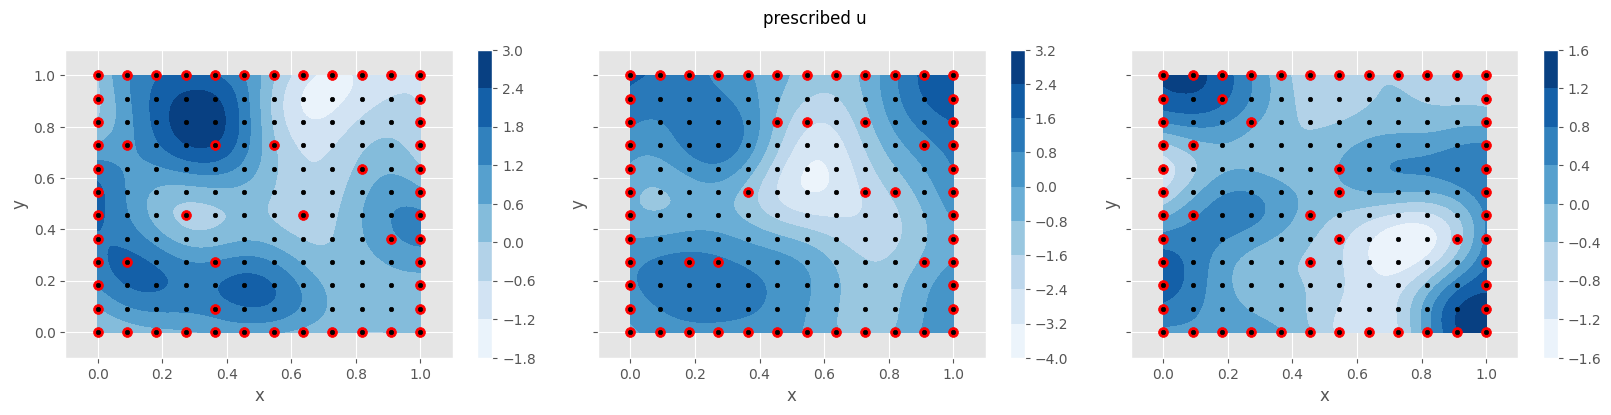

In [6]:
# Plot u's
plot_obs(xy_fine, xy_all, xy_obs, vmapped_u_true_functions, title = 'prescribed u')

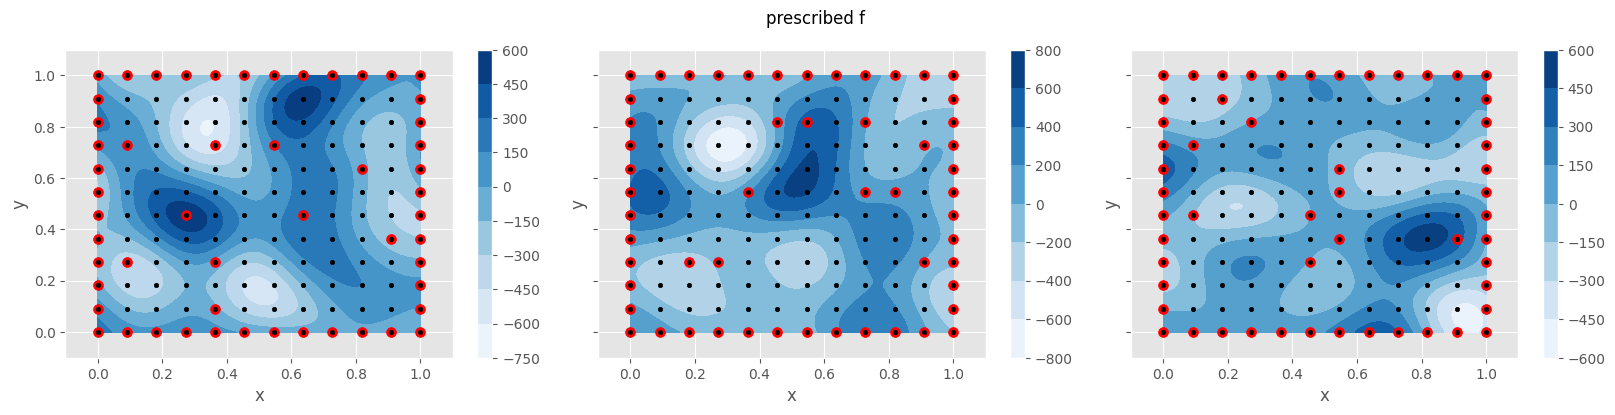

In [7]:
# Plot f's
plot_obs(xy_fine, xy_all, xy_obs, rhs_functions, title = 'prescribed f')

In [8]:
# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

In [9]:
# Build interpolants for u's
k_u = get_gaussianRBF(0.2)
u_models = tuple([InducedRKHS(
    xy_all,
    feature_operators,
    k_u
    ) for i in range(m)])

In [10]:
# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = (xy_int,)*m

rhs_values = tuple(rhs_func(xy_int) for rhs_func in rhs_functions)

all_u_params_init = tuple([model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

grid_features_u_init = jnp.vstack([(model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model,model_params in zip(u_models,all_u_params_init) ])


k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
k_P_x_part = get_gaussianRBF(0.4)
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
 

class P_model():

    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )

    num_params = len(grid_features_u_init)

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params
    
    def get_P_eval(input_data,params):
        def predict(prediction_points):
            K = P_model.kernel_function(prediction_points,input_data)
            return K@params
        return predict

In [11]:
collocation_points = tuple([xy_int]*m)
EqnModel  = OperatorPDEModel(
    P_model,
    u_models,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
)

In [12]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_int))])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-8,
    max_iter = 501,
    init_alpha=3,
    line_search_increase_ratio=2.
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 1.659e+04, Jres = 4.172e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.01e+04, Jres = 3.549e+05, alpha = 10.0, improvement_ratio = 0.4247
Iteration 2, loss = 270.6, Jres = 7.687e+05, alpha = 8.333, improvement_ratio = 0.983
Iteration 3, loss = 68.79, Jres = 6.303e+04, alpha = 6.944, improvement_ratio = 0.9939
Iteration 4, loss = 44.32, Jres = 2.466e+03, alpha = 5.787, improvement_ratio = 1.001
Iteration 5, loss = 31.39, Jres = 712.2, alpha = 4.823, improvement_ratio = 1.001
Iteration 50, loss = 0.1133, Jres = 87.07, alpha = 0.001319, improvement_ratio = 0.9435
Iteration 100, loss = 0.01899, Jres = 48.44, alpha = 0.0004416, improvement_ratio = 0.7195
Iteration 150, loss = 0.008718, Jres = 12.74, alpha = 0.0004416, improvement_ratio = 0.4075
Iteration 200, loss = 0.005188, Jres = 5.314, alpha = 0.0004416, improvement_ratio = 0.2109
Line Search Failed!
Final Iteration Results
Iteration 210, loss = 0.004857, Jres = 1.579, alpha = 1.383e+03


  0%|          | 0/500 [00:00<?, ?it/s]

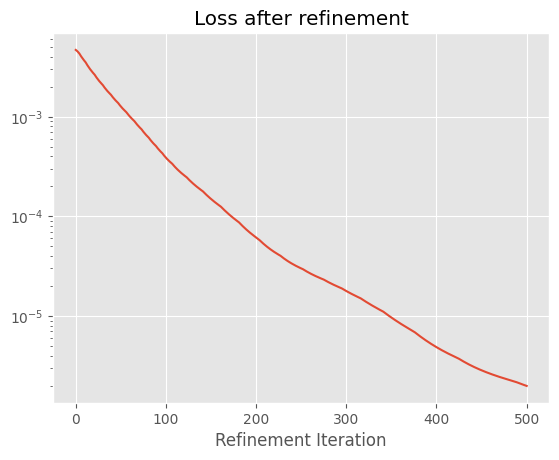

In [13]:
from LM_Solve import adaptive_refine_solution

p_adjusted,refinement_losses,reg_sequence = adaptive_refine_solution(params,EqnModel,1e-1,500)

plt.plot(refinement_losses)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')

In [14]:
u_sols = EqnModel.get_u_params(p_adjusted)
P_sol = EqnModel.get_P_params(p_adjusted)

## Measures of accuracy for u's

Results for u_1


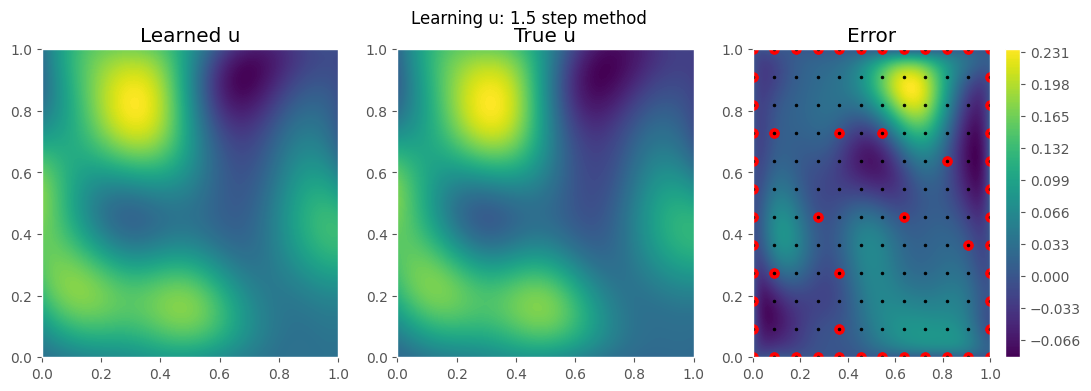

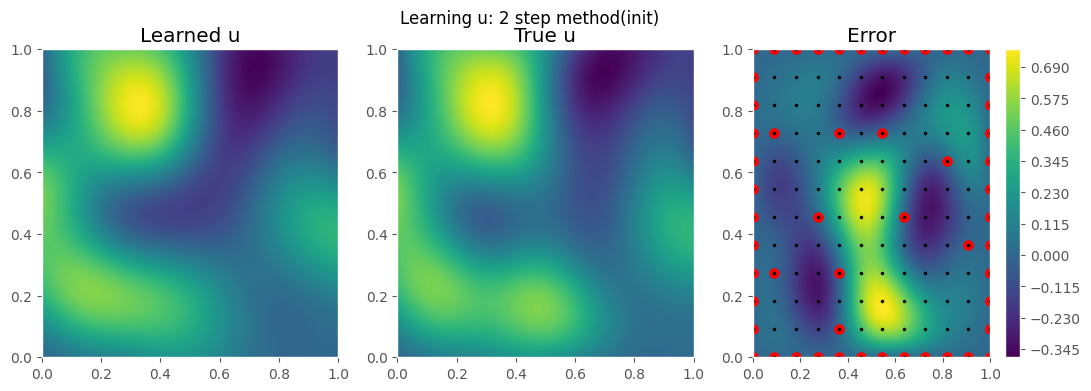

Results for u_2


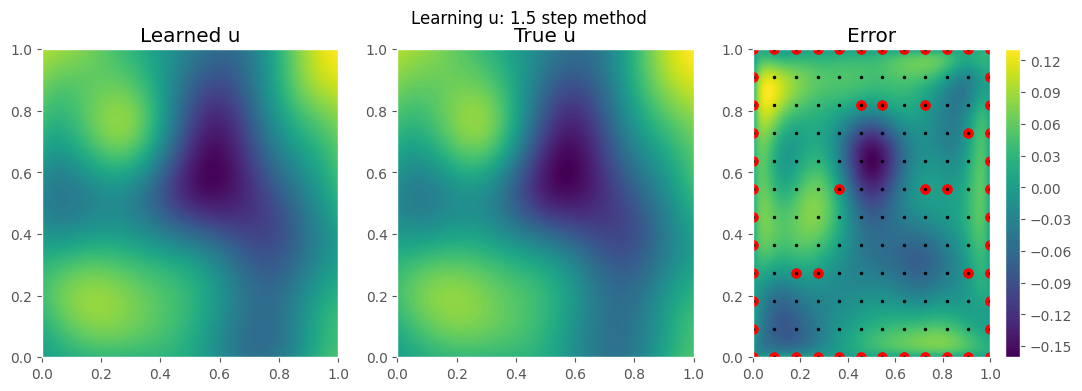

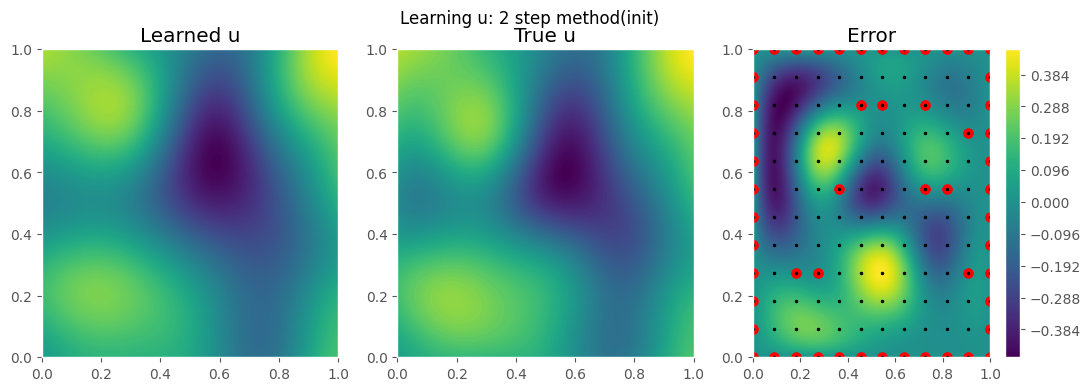

Results for u_3


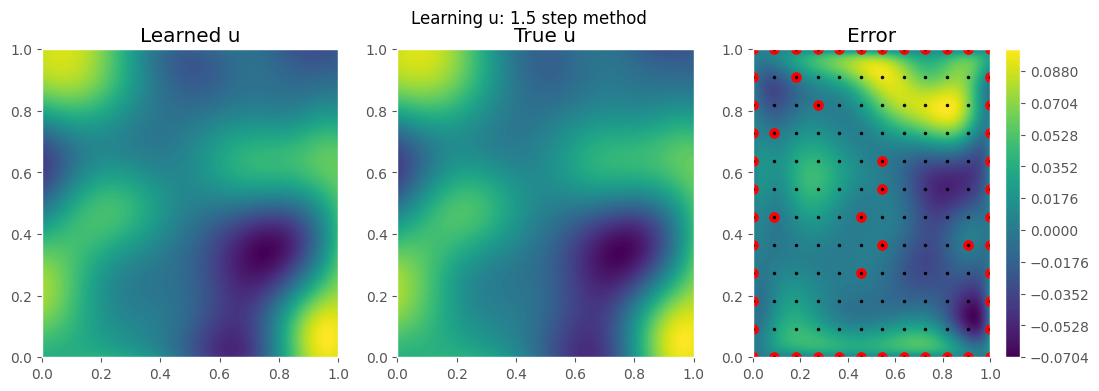

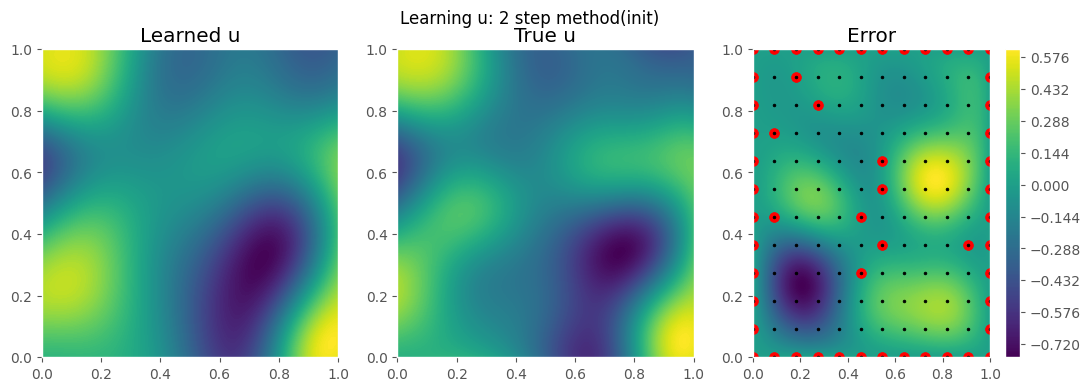

In [15]:
# Compare u's
for i in range(len(u_true_functions)):
    print(f"Results for u_{i+1}")
    # Plot 
    plot_compare_error(xy_fine,
                       xy_all,
                       xy_obs[i],
                    lambda x:u_models[i].point_evaluate(x,u_sols[i]),
                    vmapped_u_true_functions[i]
                    , title = 'Learning u: 1.5 step method')
    plot_compare_error(xy_fine,
                       xy_all,
                       xy_obs[i],
                    lambda x:u_models[i].point_evaluate(x,all_u_params_init[i]),
                    vmapped_u_true_functions[i]
                    , title = 'Learning u: 2 step method(init)')

In [16]:
table_u_errors(xy_fine, u_models, u_sols, vmapped_u_true_functions, all_u_params_init)

,1 step,2 step (at initialization)
0,4.77,20.45
1,3.66,13.53
2,5.45,37.55


## Measures of accuracy for P

Auxiliar elements for evaluation

In [17]:
# Testing grid
num_fine_grid = 50
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

# Estimated P from 1.5 step method
model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
S_train = model_grid_features_all
P_func = P_model.get_P_eval(S_train,P_sol)

# Estimated P from 2 step method
init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
S_train_2 = init_P_features 
K = P_model.kernel_function(S_train_2,S_train_2)
P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
P_func2 = P_model.get_P_eval(S_train_2,P_params_naive)

# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):

    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features


    #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
    P_preds = P_func(S_test)
    return P_preds

### In sample error

In [18]:
# Error at m training functions

# Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
true = [f(xy_fine_int) for f in rhs_functions]

u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
                  for ind in range(m)]
pred1_5 = [
    evaluate_hatP(
    P_func,
    u, xy_fine_int,feature_operators) for u in u_approx_funcs
]

twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
                  for ind in range(m)]
pred2 = [
    evaluate_hatP(
    P_func2,
    u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
]
rmses1_5 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])
rmses2 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)])
print("Average error at training functions for 1.5 step: %", round(100*jnp.mean(rmses1_5),3))
print("Average error at training functions for 2 step: %", round(100*jnp.mean(rmses2),3))

Average error at training functions for 1.5 step: % 8.704
Average error at training functions for 2 step: % 27.103


### Out of sample error

In [19]:
# Error at M testing functions
M = 50
kernel_GP = get_gaussianRBF(0.2)
# Sample M test functions from GP(0,K)
w_test_functions = GP_sampler(num_samples = M,
                X = pairs, 
                kernel = kernel_GP,
                reg = 1e-12,
                seed = 2025
                )
vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

# mean 
true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
#pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
pred1_5 = [
    evaluate_hatP(
    lambda x:P_model.kernel_function(x,S_train)@P_sol,
    w, xy_fine_int,feature_operators) for w in w_test_functions
]

pred2 = [
    evaluate_hatP(
    P_func2,
    u, xy_fine_int,feature_operators) for u in w_test_functions
]

rmses1_5 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])
rmses2 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)])
print("Average error at training functions for 1.5 step: %", round(100*jnp.mean(rmses1_5),2))
print("Average error at training functions for 2 step: %", round(100*jnp.mean(rmses2),2))

Average error at training functions for 1.5 step: % 15.93
Average error at training functions for 2 step: % 451.83


In [ ]:
# Index of the function to evaluate
eval_ind = 2
# Select u_2 of index eval_ind
eval_model = u_models[eval_ind] # Induced_RKHS object
# Select trained dual coefficients alphas_2 
eval_sol = u_sols[eval_ind] # where u(.) = alphas_2^T k_u(.,train_set)


# Create the test fine grid (interior): X_fine
num_fine_grid = 50
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

# Evaluate u_2 at the test fine grid
# u_true_interior = u_true_function1(xy_fine_int) Not being used

########### 1.5 STEP METHOD

#### GET S_TRAIN
# Get the stacked features AFTER TRAINING from u_0,u_1,u_2, i.e., [X_train_all, U(X_train_all), DU(X_train_all)] where U = [u_1,u_2,u_3] and X_train_all = [X_train1, X_train2, X_train3]
model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)

#### GET S_TEST
# Evaluate u_2 on the test grid using alphas_2
# model_fine_features_u = eval_model.evaluate_operators(feature_operators,xy_fine_int,eval_sol).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
# get array [u_2(X_fine), D u_2(X_fine)] for u_2
evaluation_u = eval_model.evaluate_operators(feature_operators,xy_fine_int,eval_sol)
# Reshape evaluation_u
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
# Stack grid_features_u with X_fine to get S_TEST = [X_fine u_2(X_fine) Du_2(X_fine)]
model_fine_features = jnp.hstack([xy_fine_int,grid_features_u])

### GET P(S_TEST)
# Evaluate P_1.5 at S_TEST 
P_preds_model_features = P_model.kernel_function(model_fine_features,model_grid_features_all)@P_sol 


############# 2 STEP METHOD


# GET S_TRAIN
# Get the stacked features BEFORE TRAINING from u_0,u_1,u_2, i.e., [X_init_all, U(X_init_all), DU(X_init_all)] where U = [u_1,u_2,u_3] and X_init_all = [X_init1, X_init2, X_init3]
init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)

# K(S_train,S_train) where S_train is done from the 2-step method
K = P_model.kernel_function(init_P_features,init_P_features)
# Get alphas for P_2 (perform Kernel ridge regression) 
P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)

### Get S_TEST
# init_fine_features_u = eval_model.evaluate_operators(feature_operators,xy_fine_int,all_u_params_init[eval_ind]).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
evaluation_u = eval_model.evaluate_operators(feature_operators,xy_fine_int,all_u_params_init[eval_ind])
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
init_fine_features = jnp.hstack([xy_fine_int,grid_features_u])

P_preds_init_model_features_init = P_model.kernel_function(init_fine_features,init_P_features)@P_params_naive


####
print("1.5 step optimized model feature predictions: %",round(100*get_nrmse(rhs_functions[eval_ind](xy_fine_int),P_preds_model_features),2))
print("2 step model feature predictions %",round(100*get_nrmse(rhs_functions[eval_ind](xy_fine_int),P_preds_init_model_features_init),2))

1.5 step optimized model feature predictions: % 10.69
2 step model feature predictions % 32.93
